In [46]:
#The directive "%" talks to Jupter Notebook directly
#matplotlib inline will embedd matplotlib graphs nicely within the code cells

%matplotlib inline

In [47]:
#import tool for accessing xml files:
import xml.etree.ElementTree as ET

import numpy as np
from numpy import asarray

#import Python Image Library (PIL)
from PIL import Image

#import matplotlib and patches to draw bounding boxes:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


#import keras
import tensorflow as tf
import keras
#from keras.models import Sequential
#Needed for Keras Functional API:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#Needed for loading an image:
from keras.preprocessing import image
#Needed for automatic plotting of CNN model: 
from keras.utils import plot_model
#Load a saved model:
from keras.models import load_model

from keras import optimizers
from keras.layers import LeakyReLU




#current path
import os
PATH = os.getcwd()
print(PATH)

/home/luc/Jupyter Notebooks/Object Localization/Dogs vs Cats


In [200]:
#Modifyable parameters (can be tweaked):
#Set resized dimensions:
resized_width = 100
resized_height = 100
#may be adjusted:
batch_size = 1
epochs = 1

#Leaky ReLU Parameters:
alpha = 0.0

#Adam Optimizer Parameters:
lr=0.0001
beta_1=0.9
beta_2=0.999


#Specify path to images:
path_to_images = '/selected dataset/selected images/'
#Specify path to xmls:
path_to_xmls = '/selected dataset/selected xmls/'

path_to_validate_images = '/selected dataset/validation images/'

path_to_validate_xmls = '/selected dataset/validation xmls/'




#Fixed parameters (cannot be changed):
num_classes = 2
num_regressions = 4
input_shape = (resized_width, resized_height, 3)

In [201]:
def load_image_set(resized_width, resized_height, path_to_images):
    
    #-------------------------------------------------------
    #Load Image Dataset:
    
    
    #define path of images to be trained
    train_img_path = PATH + path_to_images

    #define a list:
    img_train = []

    #lst = List of all images in train_img_path:
    lst = os.listdir(train_img_path)
    #sort the lst alphabetically:
    lst.sort()

    #length of the list:
    print('Number of images:', len(lst))

    #print first element of List lst:
    #print(lst[0])


    #For each image in lst: 
    for sample in lst:
        #take the specific path to that image:
        img_path = train_img_path + sample
        #load that image:
        test_image = Image.open(img_path)
        #resize that image (3 is the colour dimension):
        test_image = test_image.resize((resized_width, resized_height), 3)
        #turn it into an array:
        data1 = asarray(test_image)
        #expand that 3-dim array into 4-dim array:
        data = np.expand_dims(data1, axis=0)
        if img_path == train_img_path + lst[0]:
            #specify the first image/array to be the "total" img_array:
            img_array = data
        else:
            #append all following arrays to the img_array:
            img_array = np.append(img_array, data, axis=0)

    
    
    #for white-and-black pics (channels=1), we can normalize the data points:
    #img_array = img_array / 255
    #now we can limit the range of the values to be of type float32:
    #img_array = img_array.astype('float32')

    
    
    #check format (should be numpy.ndarray):
    print('Type of img_array:', type(img_array))
    #check shape (should be (number of pics, width, height, 3) ):
    print('Shape of img_array:', img_array.shape)


    #If error occurs, that dimensions aren't correct (concatenate), there may be a black-and-white image in the set, 
    #that cannot be transformed into (100,100,3). Solution: delete this image from the set
    
    
    return img_array
    #--------------------------------------------------------------

In [5]:
def load_label_set(resized_width, resized_height, path_to_xmls):

    #--------------------------------------------------------------
    #Load label set:
    
    
    #define path of labels:
    train_labels_path = PATH + path_to_xmls

    #list all files in directory train_labels_path:
    lst_label = os.listdir(train_labels_path)
    #sort this list:
    lst_label.sort()

    #output this list:
    #lst_label
    
    print('Type of xml label files:', type(lst_label))
    #print(lst_label[0])
    
    
    #Have a list for storing the class values:
    label_array =[]
    #Have a list for storing the bbox regression values:
    label_array_reg =[]

    #Index for counting the xml files:
    i=0

    #For any xml-files in the lst_label list:
    for sample_label in lst_label:
        #Count number of labels:
        i+=1
        #take its path:
        label_path = train_labels_path + sample_label
        #parse the xml file:
        xml = ET.parse(label_path)
        #get the root of the xml file:
        root_xml = xml.getroot()



        #Get class values:    
        #Within the root, look for the subbranch object and iterate through its objects:    
        for animal_name in root_xml.iter('object'):

            #fetch the name of the animal:
            animal = animal_name.find('name').text

            if animal == 'dog':
                animal = 1  
            else:
                animal = 0

        #Store class values in array:        
        #First of all, save class labels in small label array:
        little_array = np.array([animal])

        #If its the first xml label: 
        if label_path == train_labels_path + lst_label[0]:
            #then start off with the small array to be the "total" label array:
            label_array = np.append(label_array, little_array)
        else:
            #otherwise, all other label arrays are appended to the "total" array:
            label_array = np.append(label_array, little_array, axis=0)     




        #Get bbox values:
        #Within the root, look for subbranch bndbox and iterate through its objects:
        for bndbox in root_xml.iter('bndbox'):

            #fetch the coordinates:
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

        #Modify bbox values to respect ratio of newly dimensioned image:
        #Grab the original size of the image:    
        for orig_size in root_xml.iter('size'):

            width = float(orig_size.find('width').text)
            height = float(orig_size.find('height').text)

        #Calculate the ratios needed to apply to the original-sized-image, in order to receive the resized-image:
        #For x:
        x_ratio = resized_width/width
        #For y:
        y_ratio = resized_height/height

        #Store bbox regression values in array:   
        #First of all, save the coordinates and the class label in a small label array; 
        #modify the coordinates with the corresponding ratios:
        little_array2 = np.array([xmin*x_ratio, ymin*y_ratio, xmax*x_ratio, ymax*y_ratio])

        #If its the first xml label: 
        if label_path == train_labels_path + lst_label[0]:
            #then start off with the small array to be the "total" label array:
            label_array_reg = np.append(label_array_reg, little_array2)
        else:
            #otherwise, all other label arrays are appended to the "total" array:
            label_array_reg = np.append(label_array_reg, little_array2, axis=0)   



    #In the end, the number of labels is equivalent to the 4 parameter values times all the labels
    #These values must be the same in order for the image and the label sets to match!
    print('Number of xml files:', i)
    print('Number of bbox values devided by 4:', int(label_array_reg.shape[0]/4) )
    print('The above 2 values must be the same!\n')
    
    #Reshape to achieve format for bounding box values: (total number of labels, 4)    
    label_array_reg = np.reshape(label_array_reg, (i,4))    

    #Reshape to achieve format for class labels: (total number of labels, 1)    
    label_array = np.reshape(label_array, (i,1))
    
    #One-Hot encoding:
    #Turn (ix1)-vector of animal labels (0 or 1) into (ix2)-matrix ( (0,1) or (1,0) ): 
    label_array = keras.utils.to_categorical(label_array, num_classes)
    
    
    #check format (should be numpy.ndarray):
    print('Type of label_array:',type(label_array))
    #Shape of label_array should be (i,2):
    print('Shape of label_array:',label_array.shape)

    print('Type of label_array_reg:', type(label_array_reg))
    #Shape of label_array_reg should be (i,4):
    print('Shape of label_array_reg:',label_array_reg.shape)
    
    
    return label_array, label_array_reg
    #--------------------------------------------------    

In [6]:
#Call function to load images:
print('Loading image set:\n')
img_array = load_image_set(resized_width, resized_height, path_to_images)
print('Finished loading images into img_array!\n')


#Call function to load validation images:
print('Loading image validation set:\n')
validate_img_array = load_image_set(resized_width, resized_height, path_to_validate_images)
print('Finished loading validation images into validate_img_array!\n')


#Call function to load labels:
print('Loading label set:\n')
label_array, label_array_reg = load_label_set(resized_width, resized_height, path_to_xmls)
print('Finished loading label set into label_array and label_array_reg!\n')


#Call function to load validation labels:
print('Loading validation label set:\n')
validate_label_array, validate_label_array_reg = load_label_set(resized_width, resized_height, path_to_validate_xmls)
print('Finished loading validation label set into validate_label_array and validate_label_array_reg!\n')




Loading image set:

Number of images: 2280
Type of img_array: <class 'numpy.ndarray'>
Shape of img_array: (2280, 100, 100, 3)
Finished loading images into img_array!

Loading image validation set:

Number of images: 1400
Type of img_array: <class 'numpy.ndarray'>
Shape of img_array: (1400, 100, 100, 3)
Finished loading validation images into validate_img_array!

Loading label set:

Type of xml label files: <class 'list'>
Number of xml files: 2280
Number of bbox values devided by 4: 2280
The above 2 values must be the same!

Type of label_array: <class 'numpy.ndarray'>
Shape of label_array: (2280, 2)
Type of label_array_reg: <class 'numpy.ndarray'>
Shape of label_array_reg: (2280, 4)
Finished loading label set into label_array and label_array_reg!

Loading validation label set:

Type of xml label files: <class 'list'>
Number of xml files: 1400
Number of bbox values devided by 4: 1400
The above 2 values must be the same!

Type of label_array: <class 'numpy.ndarray'>
Shape of label_array:

In [305]:
def multi_branch_cnn(resized_width, resized_height, alpha, lr, beta_1, beta_2):

    #Base model:

    #Using Keras Functional API, the input must be a tensor:
    #This returns a tensor:
    inputs = Input(shape=(resized_width, resized_height,3))

    print('Type of inputs:', type(inputs), '\nShape of inputs:', inputs.shape)
    
    base = Conv2D(32, kernel_size=(3,3))(inputs)
    base = LeakyReLU(alpha=alpha)(base)
    base = MaxPooling2D(pool_size=(2,2))(base)

    base = Conv2D(16, kernel_size=(3,3))(base)
    base = LeakyReLU(alpha=alpha)(base)
    base = MaxPooling2D(pool_size=(2,2))(base)

    base = Conv2D(16, kernel_size=(3,3))(base)
    base = LeakyReLU(alpha=alpha)(base)
    base = MaxPooling2D(pool_size=(2,2))(base)
    
    #base = Conv2D(32, kernel_size=(3,3))(base)
    #base = LeakyReLU(alpha=alpha)(base)
    #base = MaxPooling2D(pool_size=(2,2))(base)
    
    #base = Conv2D(32, kernel_size=(5,5), activation='relu')(inputs)
    #base = MaxPooling2D(pool_size=(3,3))(base)
    
    #base = Conv2D(48, kernel_size=(5,5), activation='relu')(inputs)
    #base = MaxPooling2D(pool_size=(3,3))(base)
      
    #base = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
    #base = MaxPooling2D(pool_size=(2,2))(base)


    #Class head:

    class_head = Flatten()(base)

    #class_head = Dense(32, activation='relu')(class_head)
    #class_head = Dropout(0.25)(class_head)
    #class_head = Dense(16, activation='relu')(class_head)
    
    class_head = Dense(128)(class_head)
    class_head = LeakyReLU(alpha=alpha)(class_head)
    class_head = Dropout(0.25)(class_head)
    
    class_head = Dense(64)(class_head)
    class_head = LeakyReLU(alpha=alpha)(class_head)
    
    #class_head = Dense(128)(class_head)
    #class_head = LeakyReLU(alpha=alpha)(class_head)
    #class_head = Dropout(0.25)(class_head)
    
    #class_head = Dense(32)(class_head)
    #class_head = LeakyReLU(alpha=alpha)(class_head)
    
    class_head = Dense(16)(class_head)
    class_head = LeakyReLU(alpha=alpha)(class_head)
    #class_head = Dropout(0.25)(class_head)

    
          
    #class_head = Dense(8)(class_head)
    #class_head = LeakyReLU(alpha=alpha)(class_head)






    class_predictions = Dense(2, activation='sigmoid', name='class_output')(class_head)

    print('Shape of class_predictions:', class_predictions.shape)



    #Regression head:

    regression_head = Flatten()(base)

    #regression_head = Dense(64, activation='relu')(regression_head)
    #regression_head = Dropout(0.25)(regression_head)
    #regression_head = Dense(32, activation='relu')(regression_head)
    
    #regression_head = Dense(512)(regression_head)
    #regression_head = LeakyReLU(alpha=alpha)(regression_head)
    #regression_head = Dropout(0.25)(regression_head)
    
    regression_head = Dense(128)(regression_head)
    regression_head = LeakyReLU(alpha=alpha)(regression_head)
    
    regression_head = Dense(64)(regression_head)
    regression_head = LeakyReLU(alpha=alpha)(regression_head)
    regression_head = Dropout(0.25)(regression_head)
    
    #regression_head = Dense(64)(regression_head)
    #regression_head = LeakyReLU(alpha=alpha)(regression_head)
    
    regression_head = Dense(16)(regression_head)
    regression_head = LeakyReLU(alpha=alpha)(regression_head)
    
    #regression_head = Dense(8)(regression_head)
    #regression_head = LeakyReLU(alpha=alpha)(regression_head)




    
    #Last layer should be regressionally trained, so have ReLU activation to preserve possibly high values
    reg_predictions = Dense(num_regressions)(regression_head)
    reg_predictions = LeakyReLU(alpha=alpha, name='reg_output')(reg_predictions)


    #class Model: specify input layer and output layer:
    model = Model(inputs=inputs, outputs=[class_predictions, reg_predictions])
    
    adam = keras.optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, amsgrad=False)
    
    
    #Compile model with Optimizer, Loss-functions and metrics:
    model.compile(optimizer=adam,
              loss={'class_output': 'binary_crossentropy',
         'reg_output': 'mse'},
              metrics=['accuracy'])

    return model


In [306]:
#Function for training and saving model:
def model_train(model):
    
    #train the model with model.fit(input data, label data, epochs, batch_size):
    model.fit(img_array, {'class_output': label_array, 'reg_output': label_array_reg}, epochs=epochs, batch_size=batch_size, validation_data=(validate_img_array, {'class_output': validate_label_array, 'reg_output': validate_label_array_reg}) )  # starts training

    print('Model has finished training\n')
    
    #Save models:
    model.save("model_cnn.h5")
    print("Saved Object Localization model to disk")

In [307]:
#Call function to build model:
model = multi_branch_cnn(resized_width, resized_height, alpha, lr, beta_1, beta_2)

#Output summary of model:
print('Model Summary:\n')
model.summary()

#Plot automatic CNN model to PNG file:
plot_model(model, to_file='CNN_multi_branch_model.png')

Type of inputs: <class 'theano.tensor.var.TensorVariable'> 
Shape of inputs: Shape.0
Shape of class_predictions: Shape.0
Model Summary:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 98, 98, 32)   896         input_33[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_291 (LeakyReLU)     (None, 98, 98, 32)   0           conv2d_96[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_90 (MaxPooling2D) (None, 49, 49, 32)   0           leaky_

In [308]:
#Train CNN model:
model_train(model)

Train on 2280 samples, validate on 1400 samples
Epoch 1/1
2280/2280 [==============================] - 159s 70ms/step - loss: 527.1701 - class_output_loss: 1.4807 - reg_output_loss: 525.6894 - class_output_acc: 0.4855 - reg_output_acc: 0.6219 - val_loss: 295.7777 - val_class_output_loss: 0.6961 - val_reg_output_loss: 295.0816 - val_class_output_acc: 0.9729 - val_reg_output_acc: 0.6929
Model has finished training

Saved Object Localization model to disk


In [309]:
scores = model.evaluate(validate_img_array, {'class_output': validate_label_array, 'reg_output': validate_label_array_reg}, verbose=1)
#print('Test set loss:', scores[0])
print('\n')
print('Validation set class accuracy:', scores[3])
print('Validation set regression accuracy:', scores[4])

1400/1400 [==============================] - 17s 12ms/step


Validation set class accuracy: 0.9728571431977409
Validation set regression accuracy: 0.6928571431977408


In [310]:
#-----------------------------------
#Predictions:

In [311]:
#Load saved model:

model = load_model('model_cnn.h5')

print('Model is loaded\n')

Model is loaded



In [312]:
#Function for predicing a test image i.e. its class and its bbox:
def prediction(path_to_test_image, resized_width, resized_height):
    
    #load image from 'test' folder to be predicted;
    #transform them to the right size 100x100
    #these images are totally new to the CNN
    img = image.load_img(PATH + path_to_test_image, target_size=(resized_width, resized_height))
    #make an array out of it
    x = image.img_to_array(img)

    # Add a forth dimension since Keras expects a list of images
    x2 = np.expand_dims(x, axis=0)
    # Make a prediction with the CNN
    prediction = model.predict(x2)

    #label was either [[1. 0.]] or [[0. 1.]]
    #[[1. 0.]] means: cat
    #[[0. 1.]] means: dog
    print('Prediction:', prediction)

    #Prediction output:
    #prediction[0][0][0] will grab the first element of the array, prediction[0][0][1] the second
    if prediction[0][0][0] > prediction[0][0][1]:
        print("It's a cat!\n")
    else:
        print("It's a dog!\n")
        
    #Store predicted bbox values:
    xmin = prediction[1][0][0]
    ymin = prediction[1][0][1]
    xmax = prediction[1][0][2]
    ymax = prediction[1][0][3]


    #Create figure and axes:
    #Polar Subplot with
    #x-Axis running from left to right
    #y-Axis running from top to bottom
    fig,ax = plt.subplots(1)

    #Display the image:
    ax.imshow(img)


    #Draw bbox:
    rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r', facecolor='none')

    #Add bbox to image:
    ax.add_patch(rect)
    


Prediction: [array([[0.49868253, 0.500593  ]], dtype=float32), array([[41.223248 ,  7.6547017, 80.43891  , 75.30599  ]], dtype=float32)]
It's a dog!



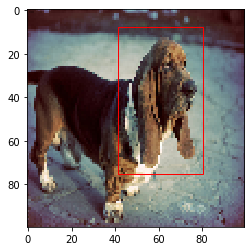

In [317]:
#Specify path to a test image:
#path_to_test_image = "/images/Abyssinian_10.jpg"
path_to_test_image = "/kicked-out images/basset_hound_2.jpg"

#Call prediction function:
prediction(path_to_test_image, resized_width, resized_height)